## Load libraries and data

In [1]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import PIL
import numpy as np

import matplotlib.pyplot as plt
## load mnist dataset
use_cuda = torch.cuda.is_available()

root = './data'
if not os.path.exists(root):
    os.mkdir(root)

## added conversion for mnist to rgb
## cf. https://discuss.pytorch.org/t/grayscale-to-rgb-transform/18315/5
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,)), transforms.Lambda(lambda x: x.repeat(3, 1, 1) )])

width = 28
height = 28

# if not exist, download mnist dataset
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

batch_size = 50

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,)

epochs = 15

print('==>>> total trainning batch number: {}'.format(len(train_loader)))
print('==>>> total testing batch number: {}'.format(len(test_loader)))

==>>> total trainning batch number: 300
==>>> total testing batch number: 50


In [2]:
print(use_cuda)

True


## define lenet

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.reshape(-1,3,28,28)
        x = x[:,0,:,:]
        x = x.reshape(-1,1,28,28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def name(self):
        return "LeNet"
    

## Export rgb images from the dataset for testing here and on khadas

5
0
4
1
9
2
3
6
7
8


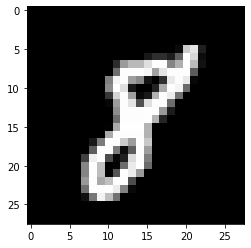

In [4]:
numbers = []
for i in range(len(train_set)):
    image, label = train_set[i]
    if label not in numbers:
        print(label)
        # denormalize
        imag=(np.array(image.tolist())+0.5) * 255
        #print(imag.shape)
        # shape image from CHW -> HWC
        imag = np.ascontiguousarray( imag.transpose((1,2,0)), dtype=np.uint8)
        #print(imag.shape)
        #print(imag.astype(np.uint8))
        pil_image = PIL.Image.frombytes('RGB',(28,28), imag)
        pil_image.save(str(label)+".bmp")
        numbers.append(label)
        
        
# visualize the last image as example
plt.imshow(imag)

## Train lenet

In [5]:
## training
model = LeNet()

if use_cuda:
    model = model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    # trainning
    ave_loss = 0
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()

        if use_cuda:
            x, target = x.cuda(), target.cuda()
        else:
            x, target = Variable(x), Variable(target)

        out = model(x)
        loss = criterion(out, target)
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        loss.backward()
        optimizer.step()
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, ave_loss))
    # testing
    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        with torch.no_grad():
            if use_cuda:
                x, target = x.cuda(), target.cuda()
            else:
                x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        # smooth average
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1
        
        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))

==>>> epoch: 0, batch index: 100, train loss: 0.580859
==>>> epoch: 0, batch index: 200, train loss: 0.216005
==>>> epoch: 0, batch index: 300, train loss: 0.163502
==>>> epoch: 0, batch index: 50, test loss: 0.101111, acc: 0.961
==>>> epoch: 1, batch index: 100, train loss: 0.115634
==>>> epoch: 1, batch index: 200, train loss: 0.103781
==>>> epoch: 1, batch index: 300, train loss: 0.076157
==>>> epoch: 1, batch index: 50, test loss: 0.053621, acc: 0.979
==>>> epoch: 2, batch index: 100, train loss: 0.084741
==>>> epoch: 2, batch index: 200, train loss: 0.084439
==>>> epoch: 2, batch index: 300, train loss: 0.068169
==>>> epoch: 2, batch index: 50, test loss: 0.044117, acc: 0.980
==>>> epoch: 3, batch index: 100, train loss: 0.053320
==>>> epoch: 3, batch index: 200, train loss: 0.059875
==>>> epoch: 3, batch index: 300, train loss: 0.052170
==>>> epoch: 3, batch index: 50, test loss: 0.033682, acc: 0.983
==>>> epoch: 4, batch index: 100, train loss: 0.048702
==>>> epoch: 4, batch ind

## Save trained lenet as pyTorch native format

In [6]:
torch.save(model, "lenet.pt")

## Predict using the stored model and previously exported example images

In [7]:
import cv2 as cv

## conv function represent different ways to implement the de-normalization
def conv_fn1(data):
    r_data = ((np.array(data) / 255.) - 0.5) / 1.0
    return r_data


def conv_fn2(data):
    r_data = ((np.array(data) - 127.5) / 255.)
    return r_data



def test_acc(model, conv_fn, verb=False, transpose=True):
    for i in range(0,9):
        im = cv.imread("%s.bmp"%i, cv.IMREAD_COLOR)
        img = conv_fn(im)
        if transpose: # HWC -> CHW
             img = img.transpose((2,0,1))
        img_tensor = torch.from_numpy(img).reshape(1,3,28,28).float()
        if use_cuda:
            model = model.cuda()
            img_tensor = img_tensor.cuda()
        out = model(img_tensor)
        res = np.argmax( out.tolist()[0] )
        print("Image is classified as %i -> should be %s"%(res, i))
        if verb:
            print(np.array(out.tolist()[0]) * 127.5 + 127.5)
    
    
    
# predict using test image using opencv (like we would do on khadas)
# load model
l_model = torch.load("lenet.pt")

test_acc(l_model, conv_fn1, verb=False)


Image is classified as 0 -> should be 0
Image is classified as 1 -> should be 1
Image is classified as 2 -> should be 2
Image is classified as 3 -> should be 3
Image is classified as 4 -> should be 4
Image is classified as 5 -> should be 5
Image is classified as 6 -> should be 6
Image is classified as 7 -> should be 7
Image is classified as 8 -> should be 8


## export lmodel to onnx -> check output of export very carefully; dont miss any error

In [9]:
def export_model_to_onnx(model):
    input_dimension = torch.randn(1, 3, 28, 28)
    if use_cuda:
        input_dimension = input_dimension.cuda()
    # very important or must leave out - not sure need to test again...
    traced = torch.jit.trace(model, input_dimension)

    torch.onnx.export(
                      traced, 
                      input_dimension, 
                      "lenet.onnx",
                      opset_version=7,
                      verbose=True,
                      export_params=True, 
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes=None
                      #dynamic_axes={'input': {0: 'batch', 2: 'height', 3: 'width'},  # shape(1,1,28,28)
                      #              'output': {0: 'batch', 1: 'classes'} }  # shape(1,10)
                      #example_outputs = torch_out
    )

export_model_to_onnx(l_model)

graph(%input : Float(1, 3, 28, 28, strides=[2352, 784, 28, 1], requires_grad=0, device=cuda:0),
      %conv1.bias : Float(20, strides=[1], requires_grad=0, device=cuda:0),
      %conv1.weight : Float(20, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=0, device=cuda:0),
      %conv2.bias : Float(50, strides=[1], requires_grad=0, device=cuda:0),
      %conv2.weight : Float(50, 20, 5, 5, strides=[500, 25, 5, 1], requires_grad=0, device=cuda:0),
      %fc1.bias : Float(500, strides=[1], requires_grad=0, device=cuda:0),
      %fc1.weight : Float(500, 800, strides=[800, 1], requires_grad=0, device=cuda:0),
      %fc2.bias : Float(10, strides=[1], requires_grad=0, device=cuda:0),
      %fc2.weight : Float(10, 500, strides=[500, 1], requires_grad=0, device=cuda:0)):
  %9 : Long(4, strides=[1], device=cpu) = onnx::Constant[value= -1   3  28  28 [ CPUDoubleType{4} ]]() # C:\Users\scholz\AppData\Local\Temp\ipykernel_3704\836706537.py:10:0
  %26 : Long(4, strides=[1], requires_grad=0, device=cpu) 

## check onnx

In [10]:
import onnx

# Load the ONNX model
onnx_model = onnx.load("lenet.onnx")

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)

# Print a Human readable representation of the graph
print( onnx.helper.printable_graph(onnx_model.graph) )

graph torch-jit-export (
  %input[FLOAT, 1x3x28x28]
) optional inputs with matching initializers (
  %conv1.bias[FLOAT, 20]
  %conv1.weight[FLOAT, 20x1x5x5]
  %conv2.bias[FLOAT, 50]
  %conv2.weight[FLOAT, 50x20x5x5]
  %fc1.bias[FLOAT, 500]
  %fc1.weight[FLOAT, 500x800]
  %fc2.bias[FLOAT, 10]
  %fc2.weight[FLOAT, 10x500]
) {
  %onnx::Cast_9 = Constant[value = <Tensor>]()
  %onnx::Reshape_26 = Cast[to = 7](%onnx::Cast_9)
  %x = Reshape(%input, %onnx::Reshape_26)
  %onnx::Cast_11 = Constant[value = <Scalar Tensor []>]()
  %onnx::Gather_27 = Cast[to = 7](%onnx::Cast_11)
  %onnx::Reshape_12 = Gather[axis = 1](%x, %onnx::Gather_27)
  %onnx::Cast_13 = Constant[value = <Tensor>]()
  %onnx::Reshape_28 = Cast[to = 7](%onnx::Cast_13)
  %input.1 = Reshape(%onnx::Reshape_12, %onnx::Reshape_28)
  %input.3 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%input.1, %conv1.weight, %conv1.bias)
  %input.7 = Relu(%input.3)
  %input.11 = MaxPool[kernel_sh